In [1]:
import torch

from torch.utils.data import DataLoader

from models import ShallowNN
from evals import test_inference

In [2]:
#baseline training
baseline_model = ShallowNN(197)
baseline_model.load_state_dict(torch.load("checkpt/baseline.pth"))

<All keys matched successfully>

In [3]:
baseline_model.eval()

ShallowNN(
  (layer_1): Linear(in_features=197, out_features=64, bias=True)
  (relu_1): ReLU()
  (layer_2): Linear(in_features=64, out_features=64, bias=True)
  (relu_2): ReLU()
  (layer_3): Linear(in_features=64, out_features=1, bias=True)
)

In [24]:
test_dataset_1 = torch.load('testpt/isopt/client_7.pt')

In [25]:
test_dl_1 = DataLoader(test_dataset_1, 128, shuffle=True)

In [26]:
loss_fn = torch.nn.MSELoss() 

In [27]:
test_inference(baseline_model, test_dl_1, loss_fn)

3.9337210655212402
0.2050768882036209


(0.9476482190083766, 0.9476482403883035)

In [51]:
import os 

import pandas as pd
import numpy as np
import seaborn as sns

from utils import load_file

In [7]:
data_path = "../kv_data/kv/"

In [11]:
data_path = "../kv_data/kv/"
files = os.listdir(data_path)
ids = [file.split(".")[0] for file in files]
files_path = [os.path.join(data_path, file) for file in files]

In [66]:
data_frame = load_file(files_path[3])

<Axes: >

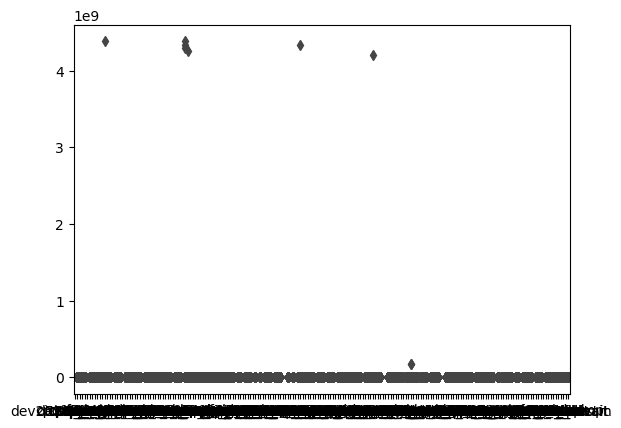

In [65]:
sns.boxplot(data=data_frame)